In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import data
import numpy.linalg as npl
from scipy.optimize import minimize
import prac_mdl_comp
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)
import sklearn.linear_model

save_dir = 'results'
os.makedirs(save_dir, exist_ok=True)


# class storing parameters for running
class p:
    seed = 15
    out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/double_descent/test'
    dset = 'gaussian' # gaussian
    beta_type = 'gaussian' # one_hot
    beta_norm = 1
    iid = 'iid' # 'iid', 'clustered', 'spike', decay, mult_decay
    n_train = 200
    n_train_over_num_features = 3 # this and num_features sets n_train
    n_test = 1000
    noise_std = 1
    noise_distr = 'gaussian' # gaussian, t, gaussian_scale_var, thresh
    model_type = 'ridge' # mdl_orig, 
    d_star = 100

# test mse vs prac-mdl objective as lambda varies (and d/n)
**note here we set ratios which are n/d instead of d/n**


0it [00:00, ?it/s]
1it [00:00,  4.38it/s]
2it [00:01,  1.54it/s]
3it [00:07,  2.18s/it]

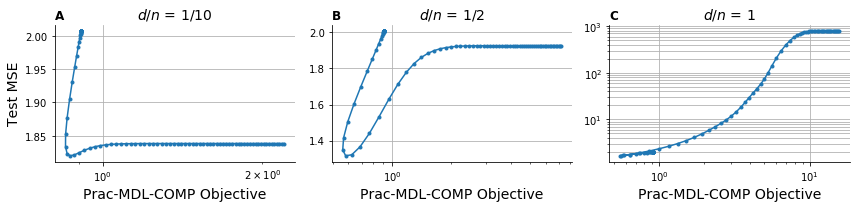


0it [00:00, ?it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:56: ComplexWarning: Casting complex values to real discards the imaginary part

1it [00:24, 24.79s/it]
2it [35:11, 643.46s/it]

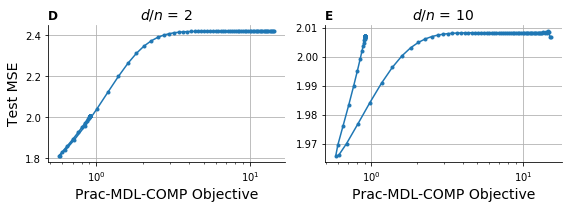

In [16]:
np.random.seed(13)
num_features_max = 2000
betastar = np.random.randn(p.d_star)
betastar = betastar / np.linalg.norm(betastar) * p.beta_norm
betastar = np.pad(betastar, (0, num_features_max - betastar.size), 'constant')
X_train_full = np.random.randn(p.n_train, num_features_max)
X_test_full = np.random.randn(p.n_test, num_features_max)
y_train = X_train_full @ betastar + p.noise_std * np.random.randn(X_train_full.shape[0])
y_test = X_test_full @ betastar + p.noise_std * np.random.randn(X_test_full.shape[0])

for top_or_bot in ['top', 'bot']:    
    if top_or_bot == 'top':
        R, C = 1, 3
        ratios = [10, 2, 1]
        plt.figure(figsize=(12, 3))
        lets = ['A', 'B', 'C']
        tits = ['1/10', '1/2', '1']
    else:
        R, C = 1, 2
        ratios = [1/2, 1/10]
        plt.figure(figsize=(8, 3))
        lets = ['D', 'E']
        tits = ['2', '10']
    for c, n_train_over_num_features in tqdm(enumerate(ratios)): #, 1/2, 1/10])):
        p.d_over_n = 1 / n_train_over_num_features
        p.num_features = int(p.d_over_n * p.n_train)
        
        X_train = X_train_full[:, :p.num_features]
        X_test = X_test_full[:, :p.num_features]
        
        eigenvals, eigenvecs = npl.eig(X_train.T @ X_train)
        var = p.noise_std**2

        def calc_thetahat(l):
            inv = npl.pinv(X_train.T @ X_train + l * np.eye(p.num_features))
            return inv @ X_train.T @ y_train

        def mdl1_loss(l):
            thetahat = calc_thetahat(l)
            mse_norm = npl.norm(y_train - X_train @ thetahat)**2 / (2 * var)
            theta_norm = npl.norm(thetahat)**2 / (2 * var)
            eigensum = 0.5 * np.sum(np.log((eigenvals + l) / l))
            return (mse_norm + theta_norm + eigensum) / y_train.size

        lambdas = np.logspace(-10, 10, num=100)
        n = lambdas.size

        r = {
            'l': lambdas,
            'mdl1': np.zeros(n),
            'test_mse': np.zeros(n)
        }
        for i, l in enumerate(lambdas):
            thetahat = calc_thetahat(l)
            r['test_mse'][i] = np.mean(np.square(y_test - X_test @ thetahat))
            r['mdl1'][i] = mdl1_loss(l)
        ax = plt.subplot(R, C, c + 1)
        plt.plot(r['mdl1'], r['test_mse'], '.-')

        plt.tight_layout()

        if c == 0:
            plt.ylabel('Test MSE', fontsize=14)

        plt.xscale('log')
        if c == 2:
            plt.yscale('log')
        plt.grid(which='major', axis='x')      
        plt.grid(which='both', axis='y')

        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        plt.xlabel('Prac-MDL-COMP Objective', fontsize=14)
        plt.title('$d/n$ = ' + tits[c], fontsize=14)
        plt.title(lets[c], loc='left', fontweight='bold')

    plt.savefig(oj(save_dir, f'fig_lambda_{top_or_bot}.pdf'))
    plt.show()

# model selection w/ prac-mdl vs ridge-cv and ols

In [ ]:
np.random.seed(13)
num_features_max = 2000
betastar = np.random.randn(p.d_star)
betastar = betastar / np.linalg.norm(betastar) * p.beta_norm
betastar = np.pad(betastar, (0, num_features_max - betastar.size), 'constant')
X_train_full = np.random.randn(p.n_train, num_features_max)
X_test_full = np.random.randn(p.n_test, num_features_max)
y_train = X_train_full @ betastar + p.noise_std * np.random.randn(X_train_full.shape[0])
y_test = X_test_full @ betastar + p.noise_std * np.random.randn(X_test_full.shape[0])

NUM = 120
ratios = np.logspace(-1, 0.3, num=NUM) # these ratios are d/n
r = {
    'ratios': ratios,
    'test_mse_mdl': np.zeros(NUM),
    'test_mse_ols': np.zeros(NUM),
    'test_mse_ridge': np.zeros(NUM)
}
for c, d_over_n in tqdm(enumerate(ratios)): #, 1/2, 1/10])):
    p.d_over_n = d_over_n
    p.num_features = int(p.d_over_n * p.n_train)
    np.random.seed(13)    

    X_train = X_train_full[:, :p.num_features]
    X_test = X_test_full[:, :p.num_features]
#     print('shape', X_train.shape, X_test.shape)

    y_pred = sklearn.linear_model.RidgeCV(alphas=np.logspace(-4, 4, num=40, base=10)).fit(X_train, y_train).predict(X_test)
    r['test_mse_ridge'][c] = np.mean(np.square(y_test - y_pred))
    
    y_pred = sklearn.linear_model.LinearRegression().fit(X_train, y_train).predict(X_test)
    r['test_mse_ols'][c] = np.mean(np.square(y_test - y_pred))
    
    theta_mdl = prac_mdl_comp.prac_mdl_comp(X_train, y_train, variance=p.noise_std**2)['thetahat']
    y_pred = X_test @ theta_mdl
    r['test_mse_mdl'][c] = np.mean(np.square(y_test - y_pred))

In [18]:
pkl.dump(r, open(oj('intermediate', 'ols_sweep_1.pkl'), 'wb'))

In [3]:
r = pkl.load(open(oj('intermediate', 'ols_sweep_1.pkl'), 'rb'))

/accounts/projects/vision/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # Remove the CWD from sys.path while we load stuff.


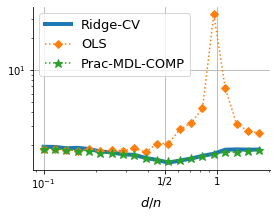

In [4]:
SKIP = 6
plt.figure(figsize=(4.25, 3))

plt.plot(r['ratios'][::SKIP], r['test_mse_ridge'][::SKIP], label='Ridge-CV',
         linewidth=4)
plt.plot(r['ratios'][::SKIP], r['test_mse_ols'][::SKIP], label='OLS', marker='D', ls=':')
plt.plot(r['ratios'][::SKIP], r['test_mse_mdl'][::SKIP], label='Prac-MDL-COMP',
         marker='*', ls=':', markersize=9, )

ax = plt.subplot(111)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.yscale('log')
plt.xscale('log')
plt.xticks([1e-1, 5e-1, 1e0], ['$10^{-1}$', '1/2', '1'])
plt.xlabel('$d / n$', fontsize=13)
plt.grid()
plt.legend(fontsize=13)
plt.title('F', loc='left', fontweight='bold')
plt.savefig(oj(save_dir, f'fig_iid_mse.pdf'),  bbox_inches = "tight")
plt.title('', loc='left', fontweight='bold')
plt.savefig(oj(save_dir, f'fig_iid_mse.svg'), bbox_inches = 'tight')
plt.show()